The aim of this project is to build a spam filter using Naive Bayes algorithm from scratch.<br>
The dataset we will use is from the <a href=https://archive.ics.uci.edu/ml/datasets/sms+spam+collection>UCI Machine Learning Repository</a><br>

The dataset has just 2 columns. They are not named, but we will name then Label and SMS.<br>
    
    -> Label - target variable spam and ham (non-spam)
    -> SMS - the message

Let us first explore the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import chain
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

In [2]:
df = pd.read_csv('SMSSpamCollection',sep='\t',header=None)
df.columns = ['Label','SMS']
print(df.shape)
df.head(5)

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Before we proceed, we should know the percentages of the targets i.e. what percentage are `spam` and what percentage are `ham` (non-spam). We will make a `countplot` for this purpose.

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

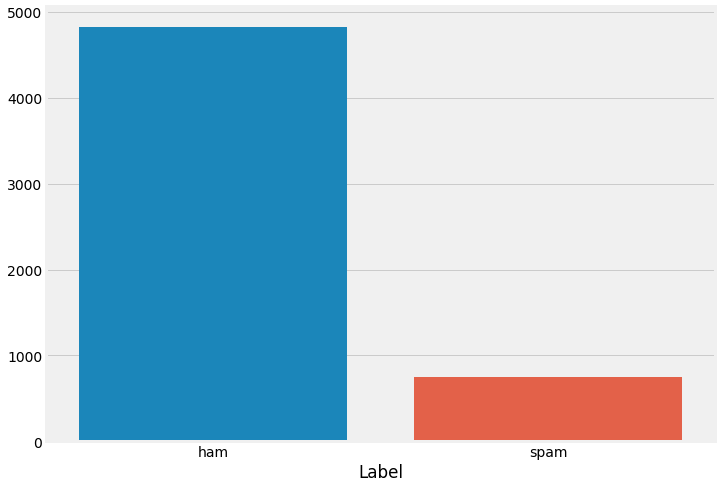

In [3]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
sns.countplot(df.Label)
plt.ylabel('')
df.Label.value_counts(normalize=True)

The dataset is not balanced i.e. the target variable doesnot have equal percentages of its classes. <br>
Now before we proceed onto building the model, we are going to split the data into train and test sets. It is always good to create testing criteria  before the building phaze as it would be unbiased.<br>

The train data will be 80% and test data 20% of the entire population. All randomly selected. We can either sample it ourselves using the `sample` function of `pandas` or we can use the `train_test_split` function from `sklearn.model_selection` module.<br>

Since we are building this spam filter from scratch, we will go with the first of the two options.

In [4]:
randomized = df.sample(frac=1,random_state=1)
train_size = round(len(randomized) * 0.8)
train = randomized[:train_size].reset_index(drop=True)
test = randomized[train_size:].reset_index(drop=True)
print(train.shape)
print(test.shape)

(4458, 2)
(1114, 2)


Now that we have the splits, let us check if these samples are representative of the population. We will check the percetages of `spam` and `ham` (non-spam) in the sample.

In [7]:
train.Label.value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [8]:
test.Label.value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

This is a good enough measure to prove that the split samples are good representatives of the population for this dataset.<br>

Now we have to clean the messages. The messages do not follow a single format, thus in order to normalize them, we will remove all punctuations, extra white spaces and convert all text to lower case.

In [9]:
train.SMS.head(10)

0                         Yep, by the pretty sculpture
1        Yes, princess. Are you going to make me moan?
2                           Welp apparently he retired
3                                              Havent.
4    I forgot 2 ask ü all smth.. There's a card on ...
5    Ok i thk i got it. Then u wan me 2 come now or...
6    I want kfc its Tuesday. Only buy 2 meals ONLY ...
7                           No dear i was sleeping :-P
8                            Ok pa. Nothing problem:-)
9                      Ill be there on  &lt;#&gt;  ok.
Name: SMS, dtype: object

In [5]:
train.SMS = train['SMS'].str.replace('\W',' ')
train.SMS = train['SMS'].str.lower()
train.SMS.head(10)

0                         yep  by the pretty sculpture
1        yes  princess  are you going to make me moan 
2                           welp apparently he retired
3                                              havent 
4    i forgot 2 ask ü all smth   there s a card on ...
5    ok i thk i got it  then u wan me 2 come now or...
6    i want kfc its tuesday  only buy 2 meals only ...
7                           no dear i was sleeping   p
8                            ok pa  nothing problem   
9                      ill be there on   lt   gt   ok 
Name: SMS, dtype: object

Now from these normalized messages we have to create the `Term Document Matrix` which is nothing but a mapping of every word to its message and the number of times the word occurs in the message.

In [6]:
messages = train.SMS.str.split()
words = list(chain(*messages))
vocabulary = pd.Series(words).unique()
len(vocabulary)

7783

We have 7783 unique words in our vocabulary. These have been retrieved from the messages. Now we have to build the term document matrix, or in our case we will be making it in the form of a dictionary.

In [7]:
no_of_messages = len(train.SMS)
word_counts = {word: [0] * no_of_messages for word in vocabulary}

for index,mssge in enumerate(messages):
    for word in mssge:
        word_counts[word][index] += 1


The above method has made a dictionary with every term in the vocabulary as key and for each term a vector identifying in which messages the term appears in and how many times.<br>

We can also achieve this using the `CountVectorizer` in the `sklearn.feature_selection.text` module. The code for it is below, we have gone ahead and removed the stop words as well.

In [16]:
token = RegexpTokenizer(r'[a-z0-9A-Z]+')
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    tokenizer = token.tokenize
)
counts = vectorizer.fit_transform(train['SMS'])
print(len(vectorizer.get_feature_names()))

word_counts = dict(zip(vectorizer.get_feature_names(),counts.toarray()))

7508


We have made the vocabulary, but we have no idea about the words. Since its a long list we cannot mannualy view it either. One solution is to create a `WordCloud` to get a gist of the data. We will create `WordClouds` for the `spam` messages and the `ham` (non-spam) messages.<br>

First let us view it for spam messages.

(-0.5, 1199.5, 799.5, -0.5)

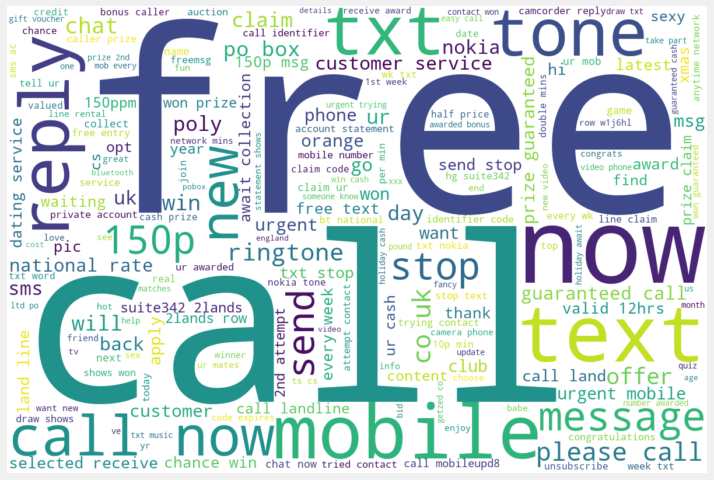

In [36]:
text = ""

for message in train[train.Label == 'spam'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords,background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

From the `wordcloud` we can see that words like - free, call, now, txt, tone, reply, mobile, text are words generally appearing in a `spam` message, and in our train set for spam messages, these have the highest frequencies.<br>

Let us do the same now for `ham` (non-spam) messages.

(-0.5, 1199.5, 799.5, -0.5)

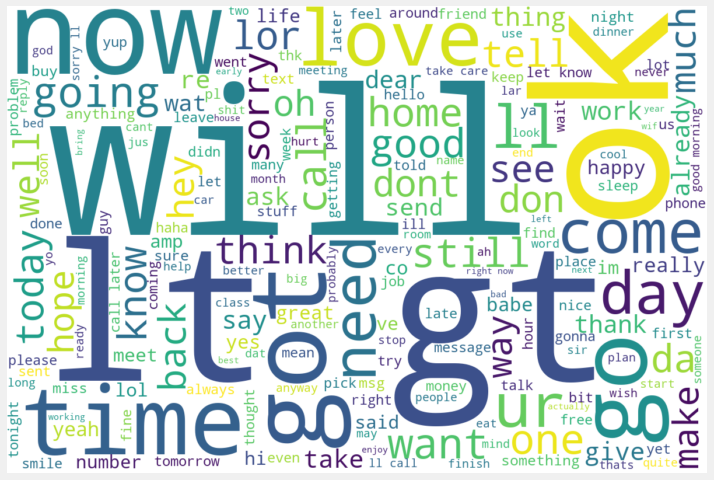

In [37]:
text = ""

for message in train[train.Label == 'ham'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords,background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

The words in `ham`(non-spam) messages are very different from the ones in `spam` messages. Words like - time, go, will, ok, love, now, come etc are more frequent amongst them.

Now we have the dictionary, we have to make it into a dataframe and append it to our existing Train sample.

In [13]:
vector_space = pd.DataFrame(word_counts)
train = pd.concat([train,vector_space],axis=1)
train.head(3)

,Label,SMS,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,ham,yep by the pretty sculpture,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,yes princess are you going to make me moan,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ham,welp apparently he retired,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have the train dataset ready. We have to apply the `Naive Bayes` algorithm now. Before we head on we will calculate some constants first:- <br>

  1.P(spam) - probability of spam<br>
  2.P(ham) - probability of non-spam<br>
  3.N<sub>spam</sub> - number of words in spam messages<br>
  4.N<sub>ham</sub> - number of words in non-spam messages<br>
  5.N<sub>vocab</sub> - number of words in vocabulary<br>
  6.Alpha - Laplace smoothing constant<br>


In [14]:
alpha = 1
P_spam = train.Label.value_counts(normalize=True)['spam']
P_ham = train.Label.value_counts(normalize=True)['ham']
N_spam = len(list(chain(*messages[train.Label == 'spam'])))
N_ham = len(list(chain(*messages[train.Label == 'ham'])))
N_vocab = len(vocabulary)

Now for calculating the paramters which are, P(w<sub>i</sub>|spam) and P(w<sub>i</sub>|ham), we can calculate these values for every term in the Matrix before hand. This makes the algorithm faster.
<br>

We will maintain a dictionary for both `spam` and `ham` dependent probabilities with words in the vocabulary. By this, during testing time we can retrieve the probability by the word.

In [15]:
P_word_given_spam = {word: 0 for word in vocabulary}
P_word_given_ham = {word: 0 for word in vocabulary}

Spam_messages = train[train.Label == 'spam']
Ham_messages = train[train.Label == 'ham']

for word in vocabulary:
    
    N_word_given_spam = Spam_messages[word].sum()
    N_word_given_ham = Ham_messages[word].sum()
    
    P_word_given_spam[word] = (
        (N_word_given_spam + alpha) / (N_spam + (alpha * N_vocab))
    )
    
    P_word_given_ham[word] = (
        (N_word_given_ham + alpha) / (N_ham + (alpha * N_vocab))
    )


Now we have all the components required to build the model already calculated. We will go on to make the spam filter. It will take an input message, calculate the probabilites- P(spam|w<sub>i</sub>..w<sub>n</sub>) and P(ham|w<sub>i</sub>..w<sub>n</sub>).

Comparing the two, if the first is greater than the latter, we classify it as `spam`, if they are equal then it requires human help, else it is classified as `ham` (non-spam)

In [16]:
def classify(message):
    
    message = re.sub('\W',' ',message)
    message = message.lower()
    message = message.split()
    
    spam = 1
    ham = 1
    
    for word in message:
        if word in P_word_given_spam.keys():
            spam *= P_word_given_spam[word]
        if word in P_word_given_ham.keys():
            ham *= P_word_given_ham[word]
        
    P_spam_given_message = P_spam * spam
    P_ham_given_message = P_ham * ham
    
#     print("P(spam|message) = ",P_spam_given_message)
#     print("P(ham|message) = ",P_ham_given_message)
    
    if P_spam_given_message > P_ham_given_message:
#         print('Label: spam')
        return 'spam'
    elif P_spam_given_message < P_ham_given_message:
#         print('Label: ham')    
        return 'ham'
    else:
#         print('Human assistance needed, equal probabilities')
        return 'Not classified'


We have our function ready, so let us test it on some test data:- 

   
    Spam - 'WINNER!! This is the secret code to unlock the money: C3421.'
    Ham (non-spam) - "Sounds good, Tom, then see u there"


In [17]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

'spam'

In [18]:
classify('Sounds good, Tom, then see u there')

'ham'

Let us try to apply the classificaton function on our test set and store those results in a new column `predicted`.

In [19]:
test['predicted'] = test.SMS.apply(classify)
test.head(5)

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [20]:
test.predicted.value_counts(normalize=True)

ham               0.869838
spam              0.129264
Not classified    0.000898
Name: predicted, dtype: float64

Out of the entire test sample, our model has classified about 86% as `ham`, about 13% as `spam` and the rest as `Not classified`. <br>

Let us now find the accuracy of the model, we simply have to compare the `Label` and the `predicted` columns and divide by the total units in the test sample.

In [21]:
accuracy = sum(test.Label == test.predicted)/len(test)
accuracy

0.9874326750448833

We have achieved a phenomenal accuracy using a simple `Naive Bayes` model built from scratch.

Let us look at the train set accuracy for our model, we have

In [22]:
train['predicted'] = train.SMS.apply(classify)
accuracy = sum(train.Label == train.predicted)/len(train)
accuracy

0.9912516823687753

In [23]:
train.predicted.value_counts(normalize=True)

ham               0.865635
spam              0.133019
Not classified    0.001346
Name: predicted, dtype: float64

Let us look at those messages that were misclassified